In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import math
import gc
from tqdm import tqdm

In [7]:
station_locations = pd.read_csv('supermag-stations-info.csv')

min_lat = 36
min_lon = 338
max_lat = 71
max_lon = 41

stations_to_remove = ['A09', 'A10', 'A11', 'ALT', 'ARK', 'ASA', 'ASH', 'B01',
						'BJI', 'C09', 'CGO', 'CPL', 'CPY', 'CWE', 'DRB', 'E01',
						'E02', 'E03', 'E04', 'EUA', 'FTN', 'FVE', 'GLK', 'GRK',
						'KAU', 'KGD', 'KOR', 'KZN', 'LNN', 'M02', 'M11', 'MCE',
						'MHV', 'MNK', 'MSK', 'MZH', 'NAD', 'NKK', 'NR2', 'NVL',
						'PKS', 'PNL', 'POD', 'PRG', 'R01', 'R02', 'R03', 'R04',
						'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'RSV', 'SAH',
						'SAS', 'SKD', 'SMA', 'SUT', 'T26', 'T27', 'T60', 'T62',
						'TKT', 'TLK', 'TOL', 'TOR', 'TTB', 'TUL', 'W01', 'W02',
						'W03', 'W04', 'W05', 'WSE', 'WTK', 'YSS', 'KHS', 'BEY', 'KLI']

station_locations = station_locations[
	station_locations['IAGA'].isin(stations_to_remove) == False
]

stations_df = station_locations[
	(station_locations['GEOLAT'] >= min_lat)
	& (station_locations['GEOLAT'] <= max_lat)
	& (
		(station_locations['GEOLON'] >= min_lon)
		| (station_locations['GEOLON'] <= max_lon)
	)
]

stations_df.reset_index(inplace=True, drop=True)

stations = stations_df['IAGA'].tolist()

  0%|          | 0/91 [00:00<?, ?it/s]

7520975
3171751


  1%|          | 1/91 [00:10<15:26, 10.29s/it]

7520975
0
7520975
7513865


  3%|▎         | 3/91 [00:34<16:52, 11.50s/it]

7520975
7198663


  4%|▍         | 4/91 [00:57<22:30, 15.53s/it]

7520975
7513522


  5%|▌         | 5/91 [01:21<26:11, 18.28s/it]

7520975
7513431


  7%|▋         | 6/91 [01:45<28:33, 20.16s/it]

7520975
5847182


  8%|▊         | 7/91 [02:03<27:17, 19.50s/it]

7520975
5943831


  9%|▉         | 8/91 [02:21<26:30, 19.16s/it]

7520975
7272893


 10%|▉         | 9/91 [02:44<27:40, 20.25s/it]

7520975
7069476


 11%|█         | 10/91 [03:06<28:05, 20.81s/it]

7520975
7491274


 12%|█▏        | 11/91 [03:30<29:01, 21.77s/it]

7520975
7383962


 13%|█▎        | 12/91 [03:54<29:26, 22.36s/it]

7520975
7515177


 14%|█▍        | 13/91 [04:18<29:46, 22.91s/it]

7520975
7194940


 15%|█▌        | 14/91 [04:41<29:33, 23.04s/it]

7520975
7508540


 16%|█▋        | 15/91 [05:05<29:20, 23.16s/it]

7520975
6852933


 18%|█▊        | 16/91 [05:26<28:23, 22.72s/it]

7520975
1935931


 19%|█▊        | 17/91 [05:32<21:50, 17.72s/it]

7520975
1851152


 20%|█▉        | 18/91 [05:38<17:11, 14.13s/it]

7520975
4798669


 21%|██        | 19/91 [05:53<17:15, 14.39s/it]

7520975
4107581


 22%|██▏       | 20/91 [06:06<16:36, 14.04s/it]

7520975
810687


 23%|██▎       | 21/91 [06:09<12:22, 10.61s/it]

7520975
2190774


 24%|██▍       | 22/91 [06:16<10:57,  9.54s/it]

7520975
7249264


 25%|██▌       | 23/91 [06:39<15:20, 13.54s/it]

7520975
7497340


 26%|██▋       | 24/91 [07:02<18:23, 16.47s/it]

7520975
6978151


 27%|██▋       | 25/91 [07:24<19:54, 18.10s/it]

7520975
4199633


 29%|██▊       | 26/91 [07:38<18:07, 16.72s/it]

7520975
5579639


 30%|██▉       | 27/91 [07:56<18:13, 17.09s/it]

7520975
7138874


 31%|███       | 28/91 [08:18<19:35, 18.66s/it]

7520975
7440066


 32%|███▏      | 29/91 [08:41<20:44, 20.07s/it]

7520975
5847264


 33%|███▎      | 30/91 [09:00<20:02, 19.71s/it]

7520975
7335031


 34%|███▍      | 31/91 [09:24<20:51, 20.86s/it]

7520975
7242643


 35%|███▌      | 32/91 [09:47<21:05, 21.44s/it]

7520975
6233484


 36%|███▋      | 33/91 [10:07<20:19, 21.03s/it]

7520975
7011214


 37%|███▋      | 34/91 [10:29<20:16, 21.35s/it]

7520975
7214628


 38%|███▊      | 35/91 [10:52<20:22, 21.82s/it]

7520975
7518013


 40%|███▉      | 36/91 [11:16<20:34, 22.45s/it]

7520975
0
7520975
6701983


 42%|████▏     | 38/91 [11:37<15:02, 17.03s/it]

7520975
3717679


 43%|████▎     | 39/91 [11:49<13:41, 15.79s/it]

7520975
3854532


 44%|████▍     | 40/91 [12:01<12:37, 14.85s/it]

7520975
7494556


 45%|████▌     | 41/91 [12:25<14:26, 17.32s/it]

7520975
7059508


 46%|████▌     | 42/91 [12:48<15:23, 18.84s/it]

7520975
5904252


 47%|████▋     | 43/91 [13:07<15:08, 18.92s/it]

7520975
7325410


 48%|████▊     | 44/91 [13:30<15:45, 20.12s/it]

7520975
6375742


 49%|████▉     | 45/91 [13:50<15:28, 20.18s/it]

7520975
7381291


 51%|█████     | 46/91 [14:14<15:54, 21.22s/it]

7520975
7519482


 52%|█████▏    | 47/91 [14:38<16:14, 22.15s/it]

7520975
7175824


 53%|█████▎    | 48/91 [15:01<15:58, 22.29s/it]

7520975
7489837


 54%|█████▍    | 49/91 [15:25<15:54, 22.72s/it]

7520975
7499466


 55%|█████▍    | 50/91 [15:49<15:48, 23.13s/it]

7520975
2104367


 56%|█████▌    | 51/91 [15:56<12:09, 18.24s/it]

7520975
7264675


 57%|█████▋    | 52/91 [16:19<12:54, 19.87s/it]

7520975
6810594


 58%|█████▊    | 53/91 [16:42<13:02, 20.58s/it]

7520975
6259395


 59%|█████▉    | 54/91 [17:02<12:37, 20.48s/it]

7520975
4914351


 60%|██████    | 55/91 [17:18<11:27, 19.09s/it]

7520975
417193


 62%|██████▏   | 56/91 [17:19<08:02, 13.78s/it]

7520975
6823033


 63%|██████▎   | 57/91 [17:41<09:08, 16.15s/it]

7520975
3901883


 64%|██████▎   | 58/91 [17:53<08:15, 15.01s/it]

7520975
7316729


 65%|██████▍   | 59/91 [18:16<09:14, 17.34s/it]

7520975
0
7520975
3933495


 67%|██████▋   | 61/91 [18:29<06:07, 12.27s/it]

7520975
7481571


 68%|██████▊   | 62/91 [18:53<07:20, 15.18s/it]

7520975
0
7520975
1160349


 70%|███████   | 64/91 [18:56<04:21,  9.68s/it]

7520975
0
7520975
0
7520975
0
7520975
0
7520975
257787


 76%|███████▌  | 69/91 [18:57<01:28,  4.01s/it]

7520975
0
7520975
0
7520975
0
7520975
6580871


 80%|████████  | 73/91 [19:18<01:21,  4.50s/it]

7520975
7201891


 81%|████████▏ | 74/91 [19:41<01:55,  6.82s/it]

7520975
4992317


 82%|████████▏ | 75/91 [19:57<02:11,  8.21s/it]

7520975
4167591


 84%|████████▎ | 76/91 [20:10<02:15,  9.05s/it]

7520975
6155298


 85%|████████▍ | 77/91 [20:29<02:35, 11.11s/it]

7520975
467199


 86%|████████▌ | 78/91 [20:30<01:56,  8.94s/it]

7520975
2502715


 87%|████████▋ | 79/91 [20:38<01:43,  8.66s/it]

7520975
4648985


 88%|████████▊ | 80/91 [20:53<01:52, 10.23s/it]

7520975
703195


 89%|████████▉ | 81/91 [20:55<01:20,  8.09s/it]

7520975
940521


 90%|█████████ | 82/91 [20:58<01:00,  6.71s/it]

7520975
553477


 91%|█████████ | 83/91 [21:00<00:42,  5.32s/it]

7520975
455050


 92%|█████████▏| 84/91 [21:02<00:29,  4.21s/it]

7520975
5018
7520975
1573782


 96%|█████████▌| 87/91 [21:07<00:10,  2.65s/it]

7520975
39750
7520975
298223


 98%|█████████▊| 89/91 [21:08<00:03,  1.65s/it]

7520975
29837
7520975
2714393


 99%|█████████▉| 90/91 [21:17<00:03,  3.67s/it]

7520975
1750756


  0%|          | 0/91 [00:00<?, ?it/s]

8408110
3171751


  1%|          | 1/91 [00:10<15:34, 10.39s/it]

8408110
4894126


  2%|▏         | 2/91 [00:26<20:02, 13.52s/it]

8408110
8406860


  3%|▎         | 3/91 [00:53<28:49, 19.65s/it]

8408110
8407583


  4%|▍         | 4/91 [01:19<32:25, 22.37s/it]

8408110
8406620


  5%|▌         | 5/91 [01:45<33:58, 23.70s/it]

8408110
8407340


  7%|▋         | 6/91 [02:12<35:01, 24.73s/it]

8408110
8351351


  8%|▊         | 7/91 [02:38<35:29, 25.35s/it]

8408110
8374819


  9%|▉         | 8/91 [03:05<35:38, 25.76s/it]

8408110
8255036


 10%|▉         | 9/91 [03:31<35:18, 25.83s/it]

8408110
8403740


 11%|█         | 10/91 [03:58<35:19, 26.17s/it]

8408110
8391987


 12%|█▏        | 11/91 [04:25<35:10, 26.39s/it]

8408110
8270982


 13%|█▎        | 12/91 [04:52<34:53, 26.50s/it]

8408110
8407775


 14%|█▍        | 13/91 [05:19<34:39, 26.66s/it]

8408110
8389608


 15%|█▌        | 14/91 [05:45<34:13, 26.67s/it]

8408110
8375016


 16%|█▋        | 15/91 [06:12<33:43, 26.62s/it]

8408110
8233599


 18%|█▊        | 16/91 [06:38<33:08, 26.52s/it]

8408110
0
8408110
0
8408110
1918591


 21%|██        | 19/91 [06:44<15:18, 12.75s/it]

8408110
7347540


 22%|██▏       | 20/91 [07:08<17:47, 15.03s/it]

8408110
0
8408110
5017145


 24%|██▍       | 22/91 [07:24<14:16, 12.41s/it]

8408110
7030461


 25%|██▌       | 23/91 [07:47<16:28, 14.54s/it]

8408110
8374305


 26%|██▋       | 24/91 [08:13<19:19, 17.30s/it]

8408110
7294669


 27%|██▋       | 25/91 [08:36<20:40, 18.80s/it]

8408110
1169043


 29%|██▊       | 26/91 [08:40<16:04, 14.84s/it]

8408110
2268083


 30%|██▉       | 27/91 [08:47<13:37, 12.77s/it]

8408110
5619668


 31%|███       | 28/91 [09:05<14:47, 14.09s/it]

8408110
6236155


 32%|███▏      | 29/91 [09:24<16:06, 15.59s/it]

8408110
2563546


 33%|███▎      | 30/91 [09:32<13:42, 13.48s/it]

8408110
3587507


 34%|███▍      | 31/91 [09:44<12:54, 12.91s/it]

8408110
7307713


 35%|███▌      | 32/91 [10:07<15:35, 15.86s/it]

8408110
6410767


 36%|███▋      | 33/91 [10:27<16:30, 17.07s/it]

8408110
7381551


 37%|███▋      | 34/91 [10:50<18:04, 19.02s/it]

8408110
4991594


 38%|███▊      | 35/91 [11:06<16:50, 18.05s/it]

8408110
8406659


 40%|███▉      | 36/91 [11:33<18:51, 20.58s/it]

8408110
1550661


 41%|████      | 37/91 [11:38<14:17, 15.87s/it]

8408110
7115192


 42%|████▏     | 38/91 [12:00<15:38, 17.70s/it]

8408110
3817013


 43%|████▎     | 39/91 [12:12<13:56, 16.08s/it]

8408110
8075288


 44%|████▍     | 40/91 [12:38<16:08, 18.99s/it]

8408110
8403686


 45%|████▌     | 41/91 [13:04<17:41, 21.23s/it]

8408110
7251215


 46%|████▌     | 42/91 [13:27<17:44, 21.73s/it]

8408110
4333162


 47%|████▋     | 43/91 [13:41<15:28, 19.34s/it]

8408110
7673402


 48%|████▊     | 44/91 [14:05<16:21, 20.87s/it]

8408110
7203427


 49%|████▉     | 45/91 [14:27<16:19, 21.29s/it]

8408110
8382896


 51%|█████     | 46/91 [14:54<17:14, 22.99s/it]

8408110
6827408


 52%|█████▏    | 47/91 [15:17<16:40, 22.75s/it]

8408110
4636739


 53%|█████▎    | 48/91 [15:32<14:38, 20.43s/it]

8408110
7878648


 54%|█████▍    | 49/91 [15:57<15:21, 21.93s/it]

8408110
7356168


 55%|█████▍    | 50/91 [16:21<15:19, 22.42s/it]

8408110
3541092


 56%|█████▌    | 51/91 [16:32<12:44, 19.10s/it]

8408110
8401177


 57%|█████▋    | 52/91 [16:58<13:46, 21.19s/it]

8408110
7289086


 58%|█████▊    | 53/91 [17:21<13:45, 21.72s/it]

8408110
5787766


 59%|█████▉    | 54/91 [17:39<12:41, 20.58s/it]

8408110
2078480


 60%|██████    | 55/91 [17:45<09:48, 16.34s/it]

8408110
89412


 62%|██████▏   | 56/91 [17:46<06:43, 11.53s/it]

8408110
4147156


 63%|██████▎   | 57/91 [17:59<06:46, 11.94s/it]

8408110
2077710


 64%|██████▎   | 58/91 [18:05<05:40, 10.31s/it]

8408110
3513956


 65%|██████▍   | 59/91 [18:16<05:36, 10.52s/it]

8408110
410923


 66%|██████▌   | 60/91 [18:17<04:00,  7.76s/it]

8408110
5683174


 67%|██████▋   | 61/91 [18:35<05:25, 10.86s/it]

8408110
4716256


 68%|██████▊   | 62/91 [18:50<05:47, 11.99s/it]

8408110
2383652


 69%|██████▉   | 63/91 [18:58<04:57, 10.62s/it]

8408110
2307694


 70%|███████   | 64/91 [19:05<04:18,  9.58s/it]

8408110
323835


 71%|███████▏  | 65/91 [19:06<03:02,  7.02s/it]

8408110
2907816


 73%|███████▎  | 66/91 [19:15<03:10,  7.61s/it]

8408110
2159097


 74%|███████▎  | 67/91 [19:21<02:56,  7.35s/it]

8408110
2994270


 75%|███████▍  | 68/91 [19:31<03:02,  7.94s/it]

8408110
276656


 76%|███████▌  | 69/91 [19:32<02:08,  5.82s/it]

8408110
2943568


 77%|███████▋  | 70/91 [19:41<02:22,  6.81s/it]

8408110
2736189


 78%|███████▊  | 71/91 [19:50<02:27,  7.39s/it]

8408110
1630393


 79%|███████▉  | 72/91 [19:55<02:07,  6.70s/it]

8408110
3021368


 80%|████████  | 73/91 [20:04<02:16,  7.58s/it]

8408110
3113105


 81%|████████▏ | 74/91 [20:14<02:19,  8.20s/it]

8408110
2526041


 82%|████████▏ | 75/91 [20:22<02:09,  8.10s/it]

8408110
2415722


 84%|████████▎ | 76/91 [20:29<01:59,  7.97s/it]

8408110
2561842


 85%|████████▍ | 77/91 [20:37<01:51,  7.96s/it]

8408110
498436


 86%|████████▌ | 78/91 [20:39<01:18,  6.05s/it]

8408110
514730


 87%|████████▋ | 79/91 [20:41<00:56,  4.73s/it]

8408110
1458723


 88%|████████▊ | 80/91 [20:45<00:51,  4.67s/it]

8408110
319737


 89%|████████▉ | 81/91 [20:46<00:35,  3.58s/it]

8408110
526180


 90%|█████████ | 82/91 [20:48<00:27,  3.01s/it]

8408110
283262


 91%|█████████ | 83/91 [20:49<00:19,  2.38s/it]

8408110
257145


 92%|█████████▏| 84/91 [20:50<00:13,  1.92s/it]

8408110
0
8408110
0
8408110
0
8408110
0
8408110
0
8408110
2050934


100%|██████████| 91/91 [20:56<00:00, 13.81s/it]


8408110
0


  0%|          | 0/91 [00:00<?, ?it/s]

4900349
0
4900349
4894126


  2%|▏         | 2/91 [00:15<11:35,  7.82s/it]

4900349
4900093


  3%|▎         | 3/91 [00:31<16:08, 11.01s/it]

4900349
4899943


  4%|▍         | 4/91 [00:46<18:25, 12.71s/it]

4900349
4899447


  5%|▌         | 5/91 [01:02<19:42, 13.75s/it]

4900349
4899825


  7%|▋         | 6/91 [01:18<20:21, 14.37s/it]

4900349
4856877


  8%|▊         | 7/91 [01:33<20:41, 14.78s/it]

4900349
4871047


  9%|▉         | 8/91 [01:49<20:48, 15.04s/it]

4900349
4886856


 10%|▉         | 9/91 [02:05<20:54, 15.30s/it]

4900349
4896471


 11%|█         | 10/91 [02:21<20:57, 15.52s/it]

4900349
4894587


 12%|█▏        | 11/91 [02:37<20:52, 15.66s/it]

4900349
4772954


 13%|█▎        | 12/91 [02:53<20:45, 15.77s/it]

4900349
4900293


 14%|█▍        | 13/91 [03:09<20:34, 15.82s/it]

4900349
4887790


 15%|█▌        | 14/91 [03:25<20:21, 15.86s/it]

4900349
4868032


 16%|█▋        | 15/91 [03:40<19:52, 15.69s/it]

4900349
4734701


 18%|█▊        | 16/91 [03:54<19:12, 15.37s/it]

4900349
0
4900349
0
4900349
0
4900349
4816547


 22%|██▏       | 20/91 [04:09<09:28,  8.01s/it]

4900349
0
4900349
4662479


 24%|██▍       | 22/91 [04:24<08:53,  7.74s/it]

4900349
3716097


 25%|██▌       | 23/91 [04:35<09:31,  8.41s/it]

4900349
4884919


 26%|██▋       | 24/91 [04:50<10:56,  9.80s/it]

4900349
4226400


 27%|██▋       | 25/91 [05:04<11:41, 10.63s/it]

4900349
0
4900349
0
4900349
2354797


 31%|███       | 28/91 [05:11<06:58,  6.64s/it]

4900349
2766761


 32%|███▏      | 29/91 [05:20<07:17,  7.06s/it]

4900349
0
4900349
165805


 34%|███▍      | 31/91 [05:21<04:40,  4.67s/it]

4900349
3994324


 35%|███▌      | 32/91 [05:33<06:11,  6.29s/it]

4900349
3598451


 36%|███▋      | 33/91 [05:45<07:13,  7.47s/it]

4900349
4215776


 37%|███▋      | 34/91 [05:59<08:29,  8.95s/it]

4900349
1662876


 38%|███▊      | 35/91 [06:04<07:28,  8.01s/it]

4900349
4899376


 40%|███▉      | 36/91 [06:19<09:06,  9.94s/it]

4900349
1553595


 41%|████      | 37/91 [06:24<07:40,  8.52s/it]

4900349
3861687


 42%|████▏     | 38/91 [06:36<08:22,  9.48s/it]

4900349
3325823


 43%|████▎     | 39/91 [06:46<08:26,  9.74s/it]

4900349
4596945


 44%|████▍     | 40/91 [07:01<09:31, 11.21s/it]

4900349
4897443


 45%|████▌     | 41/91 [07:17<10:32, 12.65s/it]

4900349
4036689


 46%|████▌     | 42/91 [07:30<10:24, 12.75s/it]

4900349
1706781


 47%|████▋     | 43/91 [07:36<08:28, 10.60s/it]

4900349
4291556


 48%|████▊     | 44/91 [07:49<09:02, 11.55s/it]

4900349
4164749


 49%|████▉     | 45/91 [08:03<09:16, 12.11s/it]

4900349
4894154


 51%|█████     | 46/91 [08:18<09:51, 13.15s/it]

4900349
3318891


 52%|█████▏    | 47/91 [08:29<09:01, 12.31s/it]

4900349
1350353


 53%|█████▎    | 48/91 [08:33<07:05,  9.91s/it]

4900349
4371741


 54%|█████▍    | 49/91 [08:47<07:45, 11.08s/it]

4900349
3847715


 55%|█████▍    | 50/91 [08:59<07:49, 11.46s/it]

4900349
1882790


 56%|█████▌    | 51/91 [09:05<06:34,  9.85s/it]

4900349
4898815


 57%|█████▋    | 52/91 [09:21<07:32, 11.61s/it]

4900349
3828114


 58%|█████▊    | 53/91 [09:33<07:28, 11.80s/it]

4900349
2604896


 59%|█████▉    | 54/91 [09:41<06:36, 10.71s/it]

4900349
0
4900349
0
4900349
688392


 63%|██████▎   | 57/91 [09:44<02:53,  5.11s/it]

4900349
0
4900349
15522
4900349
410933


 66%|██████▌   | 60/91 [09:45<01:34,  3.04s/it]

4900349
2537333


 67%|██████▋   | 61/91 [09:53<01:57,  3.92s/it]

4900349
1211537


 68%|██████▊   | 62/91 [09:57<01:53,  3.92s/it]

4900349
2387495


 69%|██████▉   | 63/91 [10:05<02:12,  4.74s/it]

4900349
1852250


 70%|███████   | 64/91 [10:11<02:15,  5.03s/it]

4900349
323719


 71%|███████▏  | 65/91 [10:12<01:44,  4.01s/it]

4900349
2911206


 73%|███████▎  | 66/91 [10:21<02:16,  5.45s/it]

4900349
2162899


 74%|███████▎  | 67/91 [10:28<02:20,  5.87s/it]

4900349
2998571


 75%|███████▍  | 68/91 [10:38<02:39,  6.95s/it]

4900349
0
4900349
2948034


 77%|███████▋  | 70/91 [10:47<02:05,  5.96s/it]

4900349
2739644


 78%|███████▊  | 71/91 [10:56<02:13,  6.65s/it]

4900349
1633333


100%|██████████| 91/91 [11:01<00:00,  7.27s/it]


4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0
4900349
0


  0%|          | 0/91 [00:00<?, ?it/s]

13141227
7513865


  1%|          | 1/91 [00:24<36:05, 24.07s/it]

13141227
8406860


  2%|▏         | 2/91 [00:50<38:01, 25.64s/it]

13141227
4900093


  3%|▎         | 3/91 [01:06<30:39, 20.90s/it]

13141227
12808377


  4%|▍         | 4/91 [01:46<41:35, 28.69s/it]

13141227
13135752


  5%|▌         | 5/91 [02:28<48:07, 33.57s/it]

13141227
13136038


  7%|▋         | 6/91 [03:10<51:21, 36.25s/it]

13141227
11240950


  8%|▊         | 7/91 [03:45<50:23, 36.00s/it]

13141227
11352631


  9%|▉         | 8/91 [04:21<49:32, 35.81s/it]

13141227
12865838


 10%|▉         | 9/91 [05:02<51:10, 37.45s/it]

13141227
12669633


 11%|█         | 10/91 [05:42<51:39, 38.27s/it]

13141227
13103057


 12%|█▏        | 11/91 [06:24<52:24, 39.31s/it]

13141227
12865525


 13%|█▎        | 12/91 [07:04<52:18, 39.73s/it]

13141227
13122021


 14%|█▍        | 13/91 [07:46<52:21, 40.27s/it]

13141227
12776591


 15%|█▌        | 14/91 [08:27<51:59, 40.51s/it]

13141227
13096559


 16%|█▋        | 15/91 [09:08<51:43, 40.84s/it]

13141227
12252420


 18%|█▊        | 16/91 [09:48<50:28, 40.39s/it]

13141227
2081982


 19%|█▊        | 17/91 [09:55<37:21, 30.29s/it]

13141227
1956361


 20%|█▉        | 18/91 [10:01<28:04, 23.08s/it]

13141227
5167906


 21%|██        | 19/91 [10:17<25:15, 21.04s/it]

13141227
9437588


 22%|██▏       | 20/91 [10:47<27:54, 23.58s/it]

13141227
866585


 23%|██▎       | 21/91 [10:49<20:14, 17.34s/it]

13141227
7095733


 24%|██▍       | 22/91 [11:12<21:49, 18.98s/it]

13141227
11681210


 25%|██▌       | 23/91 [11:49<27:42, 24.45s/it]

13141227
13099291


 26%|██▋       | 24/91 [12:31<33:09, 29.70s/it]

13141227
11909880


 27%|██▋       | 25/91 [13:09<35:18, 32.11s/it]

13141227
4511025


 29%|██▊       | 26/91 [13:23<28:58, 26.74s/it]

13141227
5963996


 30%|██▉       | 27/91 [13:43<26:06, 24.48s/it]

13141227
10175740


 31%|███       | 28/91 [14:15<28:15, 26.92s/it]

13141227
10916122


 32%|███▏      | 29/91 [14:50<30:13, 29.24s/it]

13141227
6190662


 33%|███▎      | 30/91 [15:10<26:54, 26.47s/it]

13141227
8211776


 34%|███▍      | 31/91 [15:36<26:25, 26.43s/it]

13141227
11929151


 35%|███▌      | 32/91 [16:14<29:28, 29.97s/it]

13141227
10465643


 36%|███▋      | 33/91 [16:48<30:01, 31.05s/it]

13141227
11829203


 37%|███▋      | 34/91 [17:26<31:33, 33.21s/it]

13141227
9478498


 38%|███▊      | 35/91 [17:56<30:08, 32.30s/it]

13141227
13136417


 40%|███▉      | 36/91 [18:38<32:17, 35.23s/it]

13141227
1553743


 41%|████      | 37/91 [18:44<23:33, 26.18s/it]

13141227
11087056


 42%|████▏     | 38/91 [19:19<25:34, 28.95s/it]

13141227
7366543


 43%|████▎     | 39/91 [19:42<23:35, 27.22s/it]

13141227
8866079


 44%|████▍     | 40/91 [20:10<23:18, 27.41s/it]

13141227
13107074


 45%|████▌     | 41/91 [20:51<26:13, 31.46s/it]

13141227
11668489


 46%|████▌     | 42/91 [21:27<26:56, 32.99s/it]

13141227
7998756


 47%|████▋     | 43/91 [21:53<24:29, 30.62s/it]

13141227
12250539


 48%|████▊     | 44/91 [22:31<25:46, 32.90s/it]

13141227
11118780


 49%|████▉     | 45/91 [23:06<25:41, 33.51s/it]

13141227
12986711


 51%|█████     | 46/91 [23:47<26:49, 35.76s/it]

13141227
11558557


 52%|█████▏    | 47/91 [24:23<26:22, 35.97s/it]

13141227
9228787


 53%|█████▎    | 48/91 [24:52<24:12, 33.78s/it]

13141227
12543395


 54%|█████▍    | 49/91 [25:31<24:47, 35.41s/it]

13141227
12063661


 55%|█████▍    | 50/91 [26:09<24:38, 36.07s/it]

13141227
4243777


 56%|█████▌    | 51/91 [26:22<19:29, 29.23s/it]

13141227
12853366


 57%|█████▋    | 52/91 [27:03<21:19, 32.80s/it]

13141227
11336681


 58%|█████▊    | 53/91 [27:39<21:17, 33.62s/it]

13141227
9447026


 59%|█████▉    | 54/91 [28:08<20:00, 32.46s/it]

13141227
5262546


 60%|██████    | 55/91 [28:25<16:41, 27.82s/it]

13141227
484525


 62%|██████▏   | 56/91 [28:27<11:38, 19.95s/it]

13141227
8205169


 63%|██████▎   | 57/91 [28:53<12:22, 21.83s/it]

13141227
4156637


 64%|██████▎   | 58/91 [29:07<10:36, 19.29s/it]

13141227
8042254


 65%|██████▍   | 59/91 [29:32<11:17, 21.17s/it]

13141227
410710


 66%|██████▌   | 60/91 [29:33<07:52, 15.23s/it]

13141227
6875753


 67%|██████▋   | 61/91 [29:56<08:38, 17.27s/it]

13141227
9410805


 68%|██████▊   | 62/91 [30:26<10:13, 21.16s/it]

13141227
2387642


 69%|██████▉   | 63/91 [30:33<07:59, 17.14s/it]

13141227
3085434


 70%|███████   | 64/91 [30:43<06:43, 14.96s/it]

13141227
323866


 71%|███████▏  | 65/91 [30:44<04:40, 10.79s/it]

13141227
2910980


 73%|███████▎  | 66/91 [30:54<04:18, 10.36s/it]

13141227
2163041


 74%|███████▎  | 67/91 [31:01<03:44,  9.34s/it]

13141227
2998706


 75%|███████▍  | 68/91 [31:10<03:36,  9.43s/it]

13141227
276678


 76%|███████▌  | 69/91 [31:11<02:31,  6.87s/it]

13141227
2947949


 77%|███████▋  | 70/91 [31:21<02:41,  7.67s/it]

13141227
2739796


 78%|███████▊  | 71/91 [31:30<02:40,  8.02s/it]

13141227
1633477


 79%|███████▉  | 72/91 [31:35<02:15,  7.15s/it]

13141227
6993508


 80%|████████  | 73/91 [31:56<03:27, 11.51s/it]

13141227
7689126


 81%|████████▏ | 74/91 [32:20<04:18, 15.23s/it]

13141227
5291955


 82%|████████▏ | 75/91 [32:37<04:09, 15.60s/it]

13141227
4381340


 84%|████████▎ | 76/91 [32:51<03:45, 15.06s/it]

13141227
6543667


 85%|████████▍ | 77/91 [33:12<03:55, 16.82s/it]

13141227
498468


 86%|████████▌ | 78/91 [33:13<02:39, 12.27s/it]

13141227
2737167


 87%|████████▋ | 79/91 [33:22<02:14, 11.23s/it]

13141227
4940367


 88%|████████▊ | 80/91 [33:38<02:18, 12.63s/it]

13141227
793253


 89%|████████▉ | 81/91 [33:40<01:36,  9.61s/it]

13141227
1050665


 90%|█████████ | 82/91 [33:44<01:09,  7.73s/it]

13141227
619259


 91%|█████████ | 83/91 [33:46<00:48,  6.00s/it]

13141227
512917


 92%|█████████▏| 84/91 [33:47<00:32,  4.70s/it]

13141227
5018
13141227
1705249


 95%|█████████▍| 86/91 [33:53<00:19,  3.80s/it]

13141227
86068


 96%|█████████▌| 87/91 [33:53<00:11,  2.93s/it]

13141227
378711


 97%|█████████▋| 88/91 [33:54<00:07,  2.48s/it]

13141227
60859


 98%|█████████▊| 89/91 [33:55<00:03,  1.87s/it]

13141227
2913156


 99%|█████████▉| 90/91 [34:04<00:03,  3.92s/it]

13141227
1910179


100%|██████████| 91/91 [34:10<00:00, 22.53s/it]


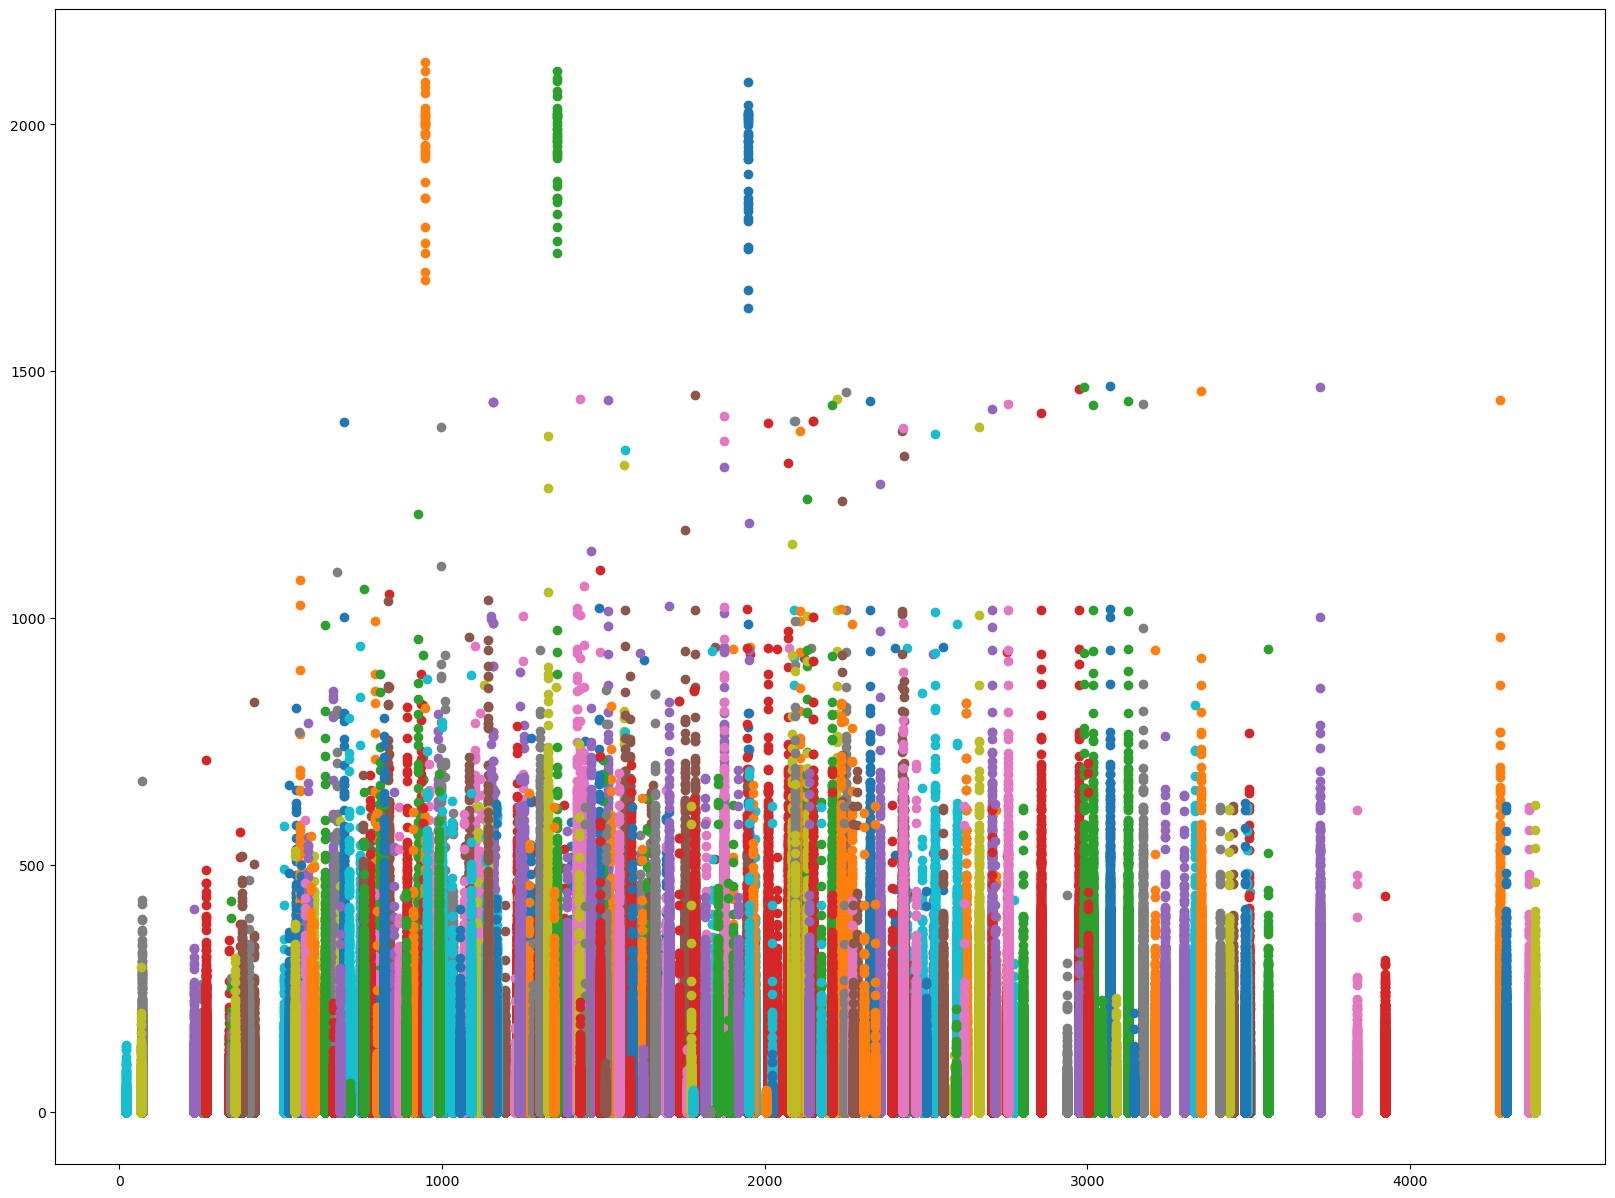

: 

In [9]:
fig = plt.figure(figsize=(20,15))
for station in stations[:4]:
	
	df = pd.read_feather(f'outputs/{station}_differences.feather')
	df.set_index('Date_UTC', inplace=True, drop=True)

	lat1 = stations_df.loc[stations_df['IAGA']==station]['GEOLAT'].item()
	lon1 = stations_df.loc[stations_df['IAGA']==station]['GEOLON'].item()
	lon1 = (lon1 + 180) % 360 - 180
	
	for col in tqdm(df.columns):
		lat2 = stations_df.loc[stations_df['IAGA']==col]['GEOLAT'].item()
		lon2 = stations_df.loc[stations_df['IAGA']==col]['GEOLON'].item()
		lon2 = (lon2 + 180) % 360 - 180
		distance = converting_from_degrees_to_km(lat1, lon1, lat2, lon2)
		print(len(df[col]))
		y = df[col].dropna().tolist()
		print(len(y))
		x = [distance] * len(y)
		plt.scatter(x, y)
	gc.collect()

plt.show()
	


In [3]:
def converting_from_degrees_to_km(lat_1, lon_1, lat_2, lon_2):

	mean_lat = (lat_1 + lat_2)/2
	x = lon_2 - lon_1
	y = lat_2 - lat_1
	dist_x = x*(111.320*math.cos(math.radians(mean_lat)))
	dist_y = y*110.574

	distance = math.sqrt((dist_x**2)+(dist_y**2))

	return distance